In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.patches import Ellipse
from skbio.diversity import beta_diversity
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from statsmodels.stats.multicomp import pairwise_tukeyhsd

Import raw data from local drive. 

In [217]:
file_name = "Experimental_Structure_Data_05012025.xlsx"
fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')

## Prepare Data

Pivot relief and substrate variables into workable format. 

In [218]:
# Step 1: Create pivot tables for Relief and Substrate counts
pivot_relief = relief.groupby(['Transect_Number', 'Relief']).size().reset_index(name='Relief_Count')
pivot_relief = pivot_relief.pivot_table(
    index='Transect_Number',  
    columns='Relief',         
    values='Relief_Count',    
    aggfunc='sum',            
    fill_value=0              
)

pivot_substrate = relief.groupby(['Transect_Number', 'Substrate']).size().reset_index(name='Substrate_Count')
pivot_substrate = pivot_substrate.pivot_table(
    index='Transect_Number',  
    columns='Substrate',      
    values='Substrate_Count', 
    aggfunc='sum',            
    fill_value=0              
)


Merge the pivot tables of raw data. Calculate standardized metrics for relief and substrate for each transect, and categorize transects as "High" or "Low" relief based on whether the mean relief values fall above or below 2, respectively. 

In [219]:
pivot_benthos = pivot_relief.join(pivot_substrate, how='outer')

mean_relief_by_transect = relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

pivot_benthos = pd.merge(pivot_benthos, mean_relief_by_transect, on='Transect_Number', how='left')

pivot_benthos['Percent_Rock'] = (pivot_benthos['Rock'] / (pivot_benthos['Rock'] + pivot_benthos['Sand'])) * 100
pivot_benthos['Percent_Sand'] = (pivot_benthos['Sand'] / (pivot_benthos['Rock'] + pivot_benthos['Sand'])) * 100

pivot_benthos['Relief_Category'] = pivot_benthos['Mean_Relief'].apply(
    lambda x: 'High' if x >= 2 else 'Low'
)


pivot_benthos

,Transect_Number,0,1,2,3,Rock,Sand,Mean_Relief,Percent_Rock,Percent_Sand,Relief_Category
0,2,0,2,4,4,10,0,2.2,100.0,0.0,High
1,3,0,3,4,3,10,0,2.0,100.0,0.0,High
2,4,0,3,5,2,10,0,1.9,100.0,0.0,Low
3,5,4,4,2,0,5,5,0.8,50.0,50.0,Low


Pivot fish variables into workable format. 

In [221]:
# Weighted size = Size_cm * Count
fish['Weighted_Size'] = fish['Size_cm'] * fish['Count']

# Weighted mean size by transect and treatment
weighted_size = fish.groupby(['Transect_Number', 'Treatment_Time']).apply(
    lambda df: df['Weighted_Size'].sum() / df['Count'].sum()
).reset_index(name='Weighted_Mean_Size_cm')

pivot_fish = fish.pivot_table(
    index=["Transect_Number", "Treatment_Time"],
    columns="Species",
    values="Count",
    fill_value=0,
    aggfunc='sum'
).reset_index()

pivot_fish = pivot_fish.merge(weighted_size, on=['Transect_Number', 'Treatment_Time'], how='left')

C:\Users\FELAB\AppData\Local\Temp\ipykernel_23556\1562020377.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_size = fish.groupby(['Transect_Number', 'Treatment_Time']).apply(


Calculate total abundance, density, biodiversity, and weighted size by transect. 

In [222]:
# Make a list of unique species ID's across the whole dataset 
species = fish["Species"].unique()
species_clean = species[~pd.isna(species)]

# Calculate the total abundance of fish observed during each treatment per transect
pivot_fish["Total_Abundance"] = pivot_fish[species_clean].sum(axis=1)

# Calculate the density of fish observed during each treatment per transect
# 1 transect = 10 m long x 2 m wide = 20 m^2
pivot_fish["Total_Density"] = pivot_fish["Total_Abundance"] / 20

# Calculate biodiversity of fishes observed during each treatment per transect 

def shannon_index(counts):
    p = counts / counts.sum()
    return -np.sum(p * np.log(p + (p == 0)))

pivot_fish["Shannon_Index"] = pivot_fish[species_clean].apply(shannon_index, axis=1)

In [156]:
pivot_fish

,Transect_Number,Treatment_Time,EJAC,ELAT,HDEC,OELO,OPIC,RNIC,RTOX,RVAC,...,SCUA,SMEL,SMIN,SMYS,SSAX,SSER,Weighted_Mean_Size_cm,Total_Abundance,Total_Density,Shannon_Index
0,1,0_hours,0,0,0,0,0,2,0,0,...,0,0,0,0,0,2,17.500000,4,0.20,0.693147
1,2,0_hours,0,0,0,0,0,0,0,0,...,0,0,0,22,0,0,12.391304,23,1.15,0.178845
2,2,1_hour,1,0,0,0,0,0,0,0,...,0,0,0,16,0,1,18.888889,18,0.90,0.425848
3,2,1_week,0,0,0,0,0,0,0,0,...,0,0,0,13,0,0,7.500000,14,0.70,0.257319
4,3,0_hours,0,0,0,0,0,0,0,0,...,0,1,0,53,0,0,11.296296,54,2.70,0.092216
5,3,1_hour,0,0,0,0,0,0,0,0,...,0,0,0,38,0,0,15.526316,38,1.90,-0.000000
6,3,1_week,0,0,0,0,0,0,1,1,...,0,0,0,21,0,0,14.038462,26,1.30,0.672296
7,4,0_hours,0,0,0,0,0,0,0,0,...,0,0,0,33,0,0,8.108108,37,1.85,0.403334
8,4,1_hour,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,11.250000,8,0.40,-0.000000
9,4,1_week,0,0,0,0,2,1,0,0,...,0,0,0,25,0,0,11.833333,30,1.50,0.672591


Combine the pivoted fish and relief datasets into a cleaned master dataset.


In [267]:
master = pd.merge(pivot_benthos, pivot_fish, on='Transect_Number', how='left')


## Fish Metrics by Treatment Time

### Summarize density, biodiversity, and size 

In [268]:
def compute_statistics(df, column_name, metric_prefix):
    # Compute the statistics for each group
    stats = df.groupby(['Treatment_Time', 'Relief_Category'])[column_name].agg(
        mean_value='mean',
        std_value='std',
        count_value='size'
    ).reset_index()

    # Rename the columns dynamically based on the metric prefix
    stats.rename(columns={
        'mean_value': f'mean_{metric_prefix}',
        'std_value': f'std_{metric_prefix}',
        'count_value': f'count_{metric_prefix}'
    }, inplace=True)

    # Calculate standard error
    stats['std_error'] = stats[f'std_{metric_prefix}'] / np.sqrt(stats[f'count_{metric_prefix}'])

    return stats

# Compute statistics for each desired column with the desired prefixes
density_stats = compute_statistics(master, 'Total_Density', 'density')
biodiversity_stats = compute_statistics(master, 'Shannon_Index', 'biodiversity')
size_stats = compute_statistics(master, 'Weighted_Mean_Size_cm', 'size')

### Run the statistics

In [269]:
metrics_to_melt = ['Weighted_Mean_Size_cm', 'Total_Density', 'Shannon_Index']  # Add other metrics if needed

melted_df = pd.melt(master, id_vars=['Transect_Number', 'Treatment_Time', 'Relief_Category'], 
                    value_vars=metrics_to_melt, 
                    var_name='Metric', value_name='Value')

In [266]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def run_two_way_anova(stats, metric_column):
    # Run the two-way ANOVA with interaction between Treatment Time and Relief Category
    model = ols(f'Value ~ C(Treatment_Time) * C(Relief_Category)', data=stats[stats['Metric'] == metric_column]).fit()
    anova_table = anova_lm(model, typ=2)  # Type II Sum of Squares
    print(f"\nANOVA Results for {metric_column}:")
    print(anova_table)
    return anova_table

def run_tukey_hsd(stats, metric_column):
    tukey = pairwise_tukeyhsd(stats[stats['Metric'] == metric_column]['Value'], 
                              stats[stats['Metric'] == metric_column]['Treatment_Time'] + ' ' + stats[stats['Metric'] == metric_column]['Relief_Category'], alpha=0.05)
    print(f"\nTukey's HSD Results for {metric_column}:")
    print(tukey.summary())
    return tukey

# Run Two-Way ANOVA and Tukey's HSD for each metric
for metric in metrics_to_melt:
    print(f"\n### Analyzing {metric} ###")
    run_two_way_anova(melted_df, metric)
    run_tukey_hsd(melted_df, metric)



### Analyzing Weighted_Mean_Size_cm ###

ANOVA Results for Weighted_Mean_Size_cm:
                                         sum_sq   df         F    PR(>F)
C(Treatment_Time)                     30.850661  2.0  3.005099  0.124682
C(Relief_Category)                    15.831289  1.0  3.084186  0.129577
C(Treatment_Time):C(Relief_Category)  25.625944  2.0  2.496170  0.162623
Residual                              30.798311  6.0       NaN       NaN

Tukey's HSD Results for Weighted_Mean_Size_cm:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------
0_hours High 0_hours Low  -2.5397 0.8571 -11.5566  6.4771  False
0_hours High 1_hour High   5.3638 0.2959   -3.653 14.3806  False
0_hours High  1_hour Low  -0.3855    1.0  -9.4023  8.6314  False
0_hours High 1_week High  -1.0746 0.9955 -10.0914  7.9423  False
0_hours High  1_week Low   0.3229    1.0   -8.694

### Plot the data

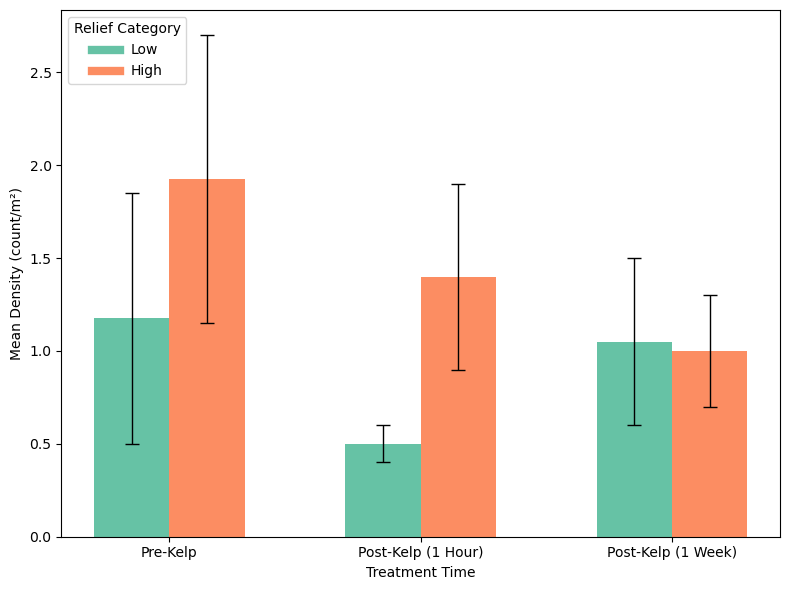

Figure saved as density_plot.jpg


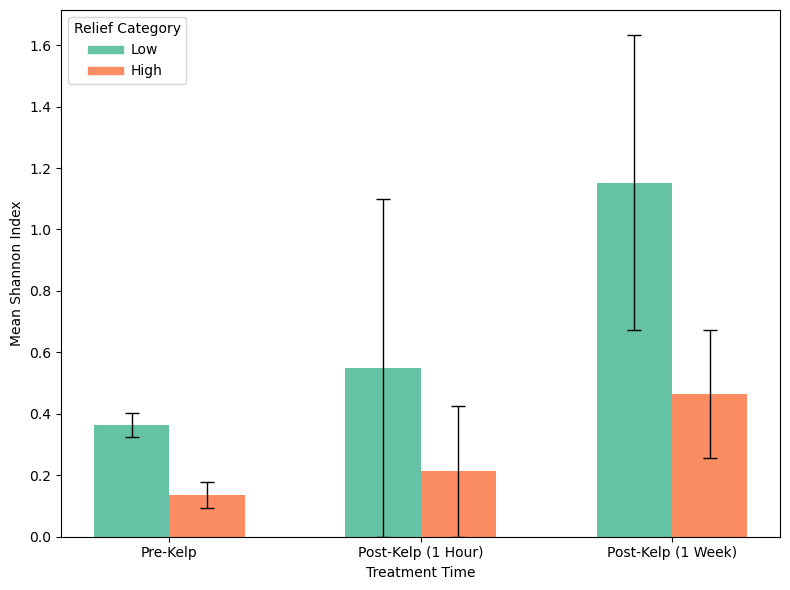

Figure saved as biodiversity_plot.jpg


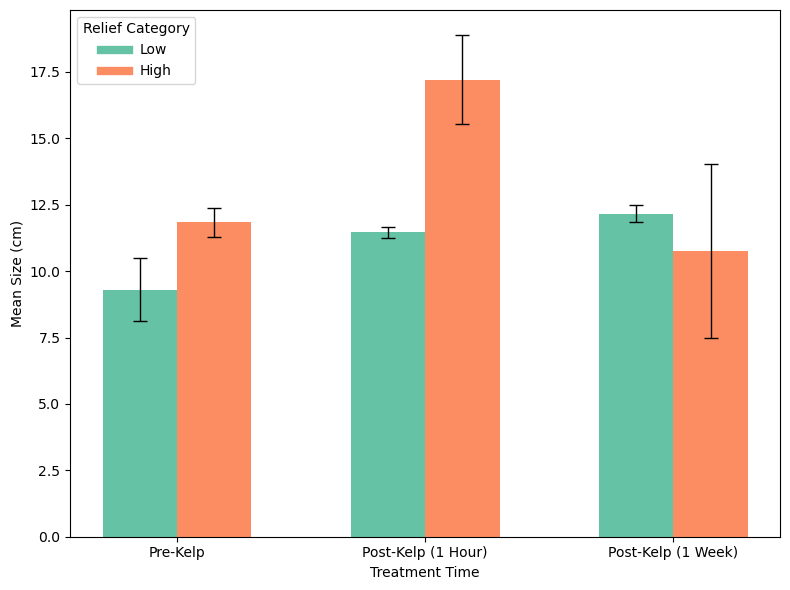

Figure saved as size_plot.jpg


In [271]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

def plot_statistics_with_simple_error_bars(stats, y_column, y_label, metric_name):

    # Set up the figure
    plt.figure(figsize=(8, 6))

    # Custom x-axis label mapping
    label_map = {'0_hours': 'Pre-Kelp', '1_hour': 'Post-Kelp (1 Hour)', '1_week': 'Post-Kelp (1 Week)'}
    stats = stats.copy()
    stats['Treatment_Label'] = stats['Treatment_Time'].map(label_map)

    # Define positions on the x-axis
    treatment_times = stats['Treatment_Time'].unique()
    treatment_labels = [label_map[t] for t in treatment_times]
    relief_categories = sorted(stats['Relief_Category'].unique(), reverse=True)

    width = 0.3  # Width of each bar
    colors = sns.color_palette("Set2", len(relief_categories))

    legend_labels = []

    for i, treatment_time in enumerate(treatment_times):
        for j, relief_category in enumerate(relief_categories):
            row = stats[(stats['Treatment_Time'] == treatment_time) & 
                        (stats['Relief_Category'] == relief_category)].iloc[0]
            
            bar_x = i + j * width
            mean_value = row[y_column]
            std_error = row['std_error']

            plt.bar(bar_x, mean_value, width=width, color=colors[j])
            plt.errorbar(bar_x, mean_value, yerr=std_error, fmt='none', 
                         color='black', capsize=5, elinewidth=1)

            if i == 0:
                legend_labels.append(relief_category)

    # Set custom x-tick positions and labels
    tick_positions = np.arange(len(treatment_times)) + (width / 2)
    plt.xticks(tick_positions, treatment_labels)

    plt.xlabel('Treatment Time')
    plt.ylabel(y_label)

    legend_handles = [Line2D([0], [0], color=colors[j], lw=6) for j in range(len(relief_categories))]
    plt.legend(legend_handles, legend_labels, title='Relief Category', loc='upper left')

    plt.tight_layout()

    # Save the figure as a jpg file
    filename = f'{metric_name}_plot.jpg'  # Name the file based on the metric name
    plt.savefig(filename, dpi=300, bbox_inches='tight', format='jpg')  # Save as .jpg with high resolution

    # Optionally, display the plot
    plt.show()

    print(f"Figure saved as {filename}")
    
# Example usage:
plot_statistics_with_simple_error_bars(density_stats, 'mean_density', 'Mean Density (count/m²)', 'density')
plot_statistics_with_simple_error_bars(biodiversity_stats, 'mean_biodiversity', 'Mean Shannon Index', 'biodiversity')
plot_statistics_with_simple_error_bars(size_stats, 'mean_size', 'Mean Size (cm)', 'size')


## Community 

Prepare data for PCA and nMDS analyses. 

In [106]:
pivot_fish['Sample_ID'] = pivot_fish['Transect_Number'].astype(str) + '_' + pivot_fish['Treatment_Time']

# Drop non-species columns
non_species_cols = ['Transect_Number', 'Treatment_Time', 'Total_Abundance', 
                    'Total_Density', 'Shannon_Index', 'Sample_ID']

species_data = pivot_fish.drop(columns=non_species_cols)
species_data = species_data.fillna(0)

Calculate PCA scores.

In [107]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(species_data)

In [108]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(scaled_data)

# Add PCA results back to the dataframe
pca_df = pd.DataFrame(pca_scores, columns=['PC1', 'PC2'])
pca_df['Treatment_Time'] = pivot_fish['Treatment_Time']
pca_df['Transect'] = pivot_fish['Transect_Number'].astype(str)

Calculate confidence intervals for PCA. 

In [109]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', edgecolor='black', **kwargs):
    """
    Draw a confidence ellipse of `n_std` standard deviations.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    if np.linalg.det(cov) == 0:
        return  # skip degenerate cases

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    # Compute the ellipse angle and width/height
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      edgecolor=edgecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    transf = (plt.matplotlib.transforms.Affine2D()
              .rotate_deg(45)
              .scale(scale_x, scale_y)
              .translate(mean_x, mean_y))

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Plot PCA with 95% confidence interval ellipses. 

NameError: name 'x_min' is not defined

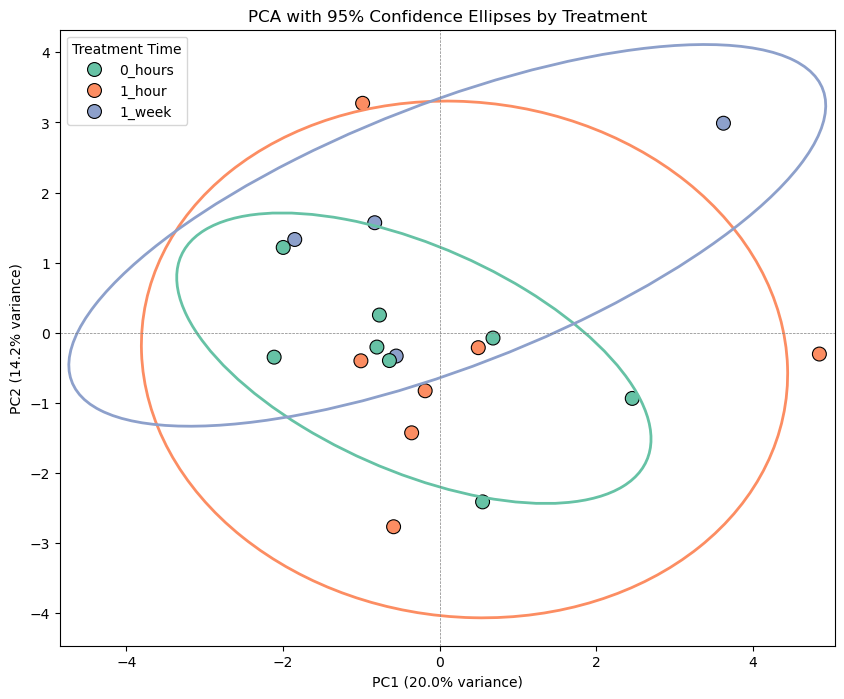

In [110]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Base scatter
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Treatment_Time', s=100, palette='Set2', ax=ax, edgecolor='black')

# Add ellipses
colors = dict(zip(pca_df['Treatment_Time'].unique(), sns.color_palette('Set2')))

for treatment in pca_df['Treatment_Time'].unique():
    subset = pca_df[pca_df['Treatment_Time'] == treatment]
    if len(subset) >= 3:
        confidence_ellipse(
            subset['PC1'].values, subset['PC2'].values, ax,
            n_std=2, edgecolor=colors[treatment], linewidth=2, facecolor='none'
        )

plt.title('PCA with 95% Confidence Ellipses by Treatment')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend(title='Treatment Time')

# After adding all ellipses and legend:
ax.relim()
ax.autoscale_view()

# Or use manual buffer if relim doesn't help
plt.xlim(x_min - 1, x_max + 1)
plt.ylim(y_min - 1, y_max + 1)

plt.tight_layout()
plt.show()

Calculate Bray Curtis distances for nMDS. 

In [279]:
bray_curtis_distances = beta_diversity("braycurtis", species_data.values, ids=species_data.index)

# Run nMDS (non-metric multidimensional scaling)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(bray_curtis_distances.data) 
# Create a plotting DataFrame
mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2'])
mds_df['Treatment_Time'] = pivot_fish['Treatment_Time'].values  # Replace with actual metadata

In [280]:
# `species_data`: rows = samples, columns = species
# `mds_df`: includes MDS1, MDS2, and Treatment_Time

# Step 1: Compute correlations of each species with MDS axes
species_vectors = pd.DataFrame(index=species_data.columns, columns=['r_MDS1', 'r_MDS2'])

for species in species_data.columns:
    species_vectors.loc[species, 'r_MDS1'] = np.corrcoef(species_data[species], mds_df['MDS1'])[0, 1]
    species_vectors.loc[species, 'r_MDS2'] = np.corrcoef(species_data[species], mds_df['MDS2'])[0, 1]

# Convert to numeric
species_vectors = species_vectors.astype(float)


In [281]:
def plot_ellipse(x, y, ax, edgecolor='black', **kwargs):
    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Eigen decomposition for ellipse axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2 * np.sqrt(eigvals)  # 1 std dev ellipse

    ellipse = mpatches.Ellipse((mean_x, mean_y), width, height, angle=angle,
                               edgecolor=edgecolor, facecolor='none', lw=1.5, **kwargs)
    ax.add_patch(ellipse)


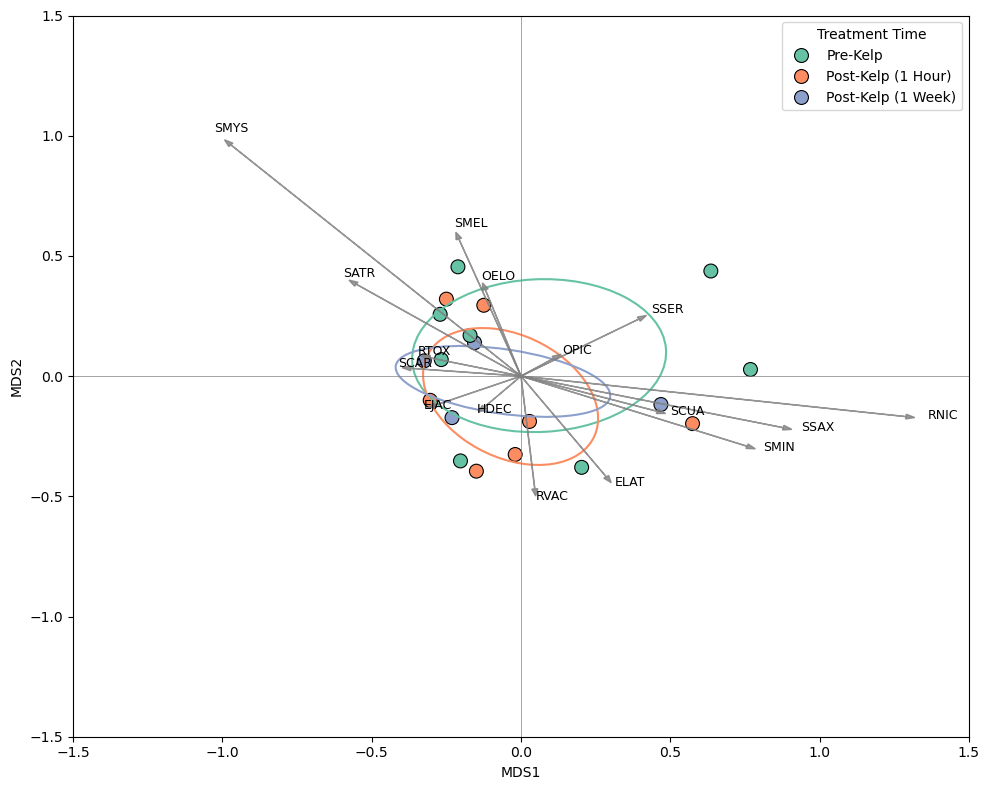

In [285]:
# Set up plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot MDS points
sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Treatment_Time',
                palette='Set2', s=100, edgecolor='black', ax=ax)

# Add ellipses for each treatment group
for treatment in mds_df['Treatment_Time'].unique():
    subset = mds_df[mds_df['Treatment_Time'] == treatment]
    if len(subset) >= 3:  # Need at least 3 points to define an ellipse
        plot_ellipse(subset['MDS1'], subset['MDS2'], ax,
                     edgecolor=sns.color_palette('Set2')[list(mds_df['Treatment_Time'].unique()).index(treatment)])

# Plot species arrows for top species
for species, row in species_vectors.iterrows():
    ax.arrow(0, 0, row['r_MDS1'] * 1.5, row['r_MDS2'] * 1.5,
             color='gray', alpha=0.8, head_width=0.02, length_includes_head=True)
    ax.text(row['r_MDS1'] * 1.55, row['r_MDS2'] * 1.55, species, fontsize=9)

# Add axis lines
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)
plt.xlim([-1.5, 1.5])  # Adjust the x-axis range
plt.ylim([-1.5, 1.5])  # Adjust the y-axis range

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Manually create a list of legend labels that correspond to the Treatment Times
treatment_labels = ['Pre-Kelp', 'Post-Kelp (1 Hour)', 'Post-Kelp (1 Week)']

# Ensure the correct order of labels is maintained
# We use the hue values to map the correct treatment time to colors
treatment_time_order = ['0_hours', '1_hour', '1_week']  # Match with your `Treatment_Time` categories
label_map = {'0_hours': 'Pre-Kelp', '1_hour': 'Post-Kelp (1 Hour)', '1_week': 'Post-Kelp (1 Week)'}
label_dict = dict(zip(treatment_time_order, treatment_labels))

# Create the correct legend with proper labels corresponding to treatments
plt.legend(handles=handles, labels=[label_dict[label] for label in labels], title='Treatment Time')

# Adjust layout to avoid clipping
plt.tight_layout()

# Save the figure as a jpg file
plt.savefig('Species_nMDS_plot.jpg', dpi=300, bbox_inches='tight', format='jpg')

# Show the plot
plt.show()

